# Project: Retinal vessel segmentation

The segmentation of retinal blood vessels from eye fundus images is of great significance for early diagnosis of eye-related diseases such as diabetes and hypertension.

The goal of this project is to read an eye fundus image like the following:
![](https://dlsi.ua.es/~pertusa/tvainput21.png)

And extract the blood vessels as can be seen in the corresponding ground-truth sample:

![](https://dlsi.ua.es/~pertusa/tvagt21.png)

All the images for this project are extracted from the [Drive](https://drive.grand-challenge.org) dataset.

For this task you can use any computer vision technique **except by deep neural networks, that are not allowed in this project**.

**Implementation**

To begin with the project, first download from moodle the folder with all the images and upload it to google drive.

Then, import the following libraries (you can add more):

In [3]:
import os
import cv2 as cv
import numpy as np 
from matplotlib import pyplot as plt
import maxflow

db_path = 'images/'

Now you should edit the following function to segment the image and return the obtained segmentation. This is only a simple (basic) skeleton that obviously is not performing well. Your project's goal is basically to complete this function. You can read the attached papers in Moodle to get ideas for the segmentation.

#### Graph-Cut

In [23]:
def manual_retinex(img, sigma_d=0.3, sigma_r=0.3):
    """
    Retinex-based Inhomogeneity Correction using bilateral filtering.
    
    Based on Zhao et al. "Retinal Vessel Segmentation: An Efficient Graph Cut 
    Approach with Retinex and Local Phase"
    
    Parameters:
    -----------
    img : numpy array
        Input image (should be normalized to [0,1] range)
    sigma_d : float
        Spatial standard deviation for bilateral filter
    sigma_r : float
        Range standard deviation for bilateral filter
    
    Returns:
    --------
    R : numpy array
        Reflectance image (Retinex output)
    """
    # Normalize to prevent overflow
    if img.dtype == np.uint8:
        img = img.astype(np.float64) / 255.0
    else:
        img = img.astype(np.float64)
    
    # Pad image for 3x3 window
    padded_img = cv.copyMakeBorder(img, 1, 1, 1, 1, cv.BORDER_REFLECT)
    
    # Initialize L(x) - the illumination component
    L = np.zeros_like(img, dtype=np.float64)
    
    # For each pixel
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            # Extract 3x3 window
            W = padded_img[i:i+3, j:j+3]
            
            # Current pixel value
            I_x = img[i, j]
            
            # Compute spatial distance (geometric closeness)
            x_coords, y_coords = np.meshgrid(np.arange(-1, 2), np.arange(-1, 2))
            spatial_dist = np.sqrt(x_coords**2 + y_coords**2)
            g_kernel = np.exp(-(spatial_dist**2) / (2.0 * sigma_d**2))
            
            # Compute intensity similarity (range closeness)
            intensity_diff = W - I_x
            s_kernel = np.exp(-(intensity_diff**2) / (2.0 * sigma_r**2))
            
            # Combined bilateral filter weight
            bilateral_weight = g_kernel * s_kernel
            
            # Normalization factor M(x)
            M = np.sum(bilateral_weight)
            
            # Compute L(x) - weighted average of intensities in window
            if M > 0:
                L[i, j] = np.sum(bilateral_weight * W) / M
            else:
                L[i, j] = I_x
    
    # Compute reflectance R(x) in log domain
    # R(x) = log(I(x) + 1) - log(L(x) + 1)
    R = np.log(img + 1) - np.log(L + 1)
    
    # Normalize R to [0, 1]
    R_min = np.min(R)
    R_max = np.max(R)
    
    if R_max > R_min:
        R = (R - R_min) / (R_max - R_min)
    else:
        R = np.zeros_like(R)
    
    return R

def bilateral_retinex(img, threshold=0.05):
    if img.dtype == np.uint8:
        img = (img.astype(np.float32) - np.min(img)) / (np.max(img) - np.min(img)) # Normalize to [0, 1] to prevent overflow
    else:
        img = img.astype(np.float32)

    mask = (img > threshold).astype(np.uint8)
    
    # Apply bilateral filter only to the masked region
    L = np.zeros_like(img)
    img_uint8 = (img * 255).astype(np.uint8)
    L_filtered = cv.bilateralFilter(img_uint8, d=15, sigmaColor=75, sigmaSpace=75)
    L_filtered = L_filtered.astype(np.float32) / 255.0
    L = np.where(mask, L_filtered, 0)

    # Compute reflectance R(x) in log domain
    # R(x) = log(I(x) + 1) - log(L(x) + 1)
    R = np.log(img + 1) - np.log(L + 1)

    # Apply mask to R to ensure background remains black
    R = R * mask

    # Normalize R to [0, 1] only for non-zero regions
    R_masked = R[mask > 0]
    R[mask > 0] = (R_masked - np.min(R_masked)) / (np.max(R_masked) - np.min(R_masked) + 1e-10)

    return R # return reflectance image normalized to [0, 1]

def local_phase_enhancement(img, mask_img, scales=[4,8], orientations=4, beta=1.0, alpha=0.5):
    """
    scales: Reduced to [1, 3, 6] for tighter vessels.
    beta: Increased to 2.0 to reduce granularity/noise.
    mask_img: The binary mask of the Field of View (FOV).
    """
    
    # 1. Pre-processing: Erode the mask to remove the boundary artifact
    erosion_kernel = np.ones((8, 8), np.uint8) 
    clean_mask = cv.erode(mask_img, erosion_kernel, iterations=1)

    img_float = img.astype(np.float32)
    if img.max() > 1.0: img_float /= 255.0

    scale_responses = []
    thetas = np.linspace(0, np.pi, orientations, endpoint=False)

    for wavelength in scales:
        sigma = 0.55 * wavelength
        k = int(3 * sigma * 2) + 1
        if k % 2 == 0: k += 1
        ksize = (k, k)

        sum_even = np.zeros_like(img_float)
        sum_odd = np.zeros_like(img_float)

        for theta in thetas:
            kern_even = cv.getGaborKernel(ksize, sigma, theta, wavelength, gamma=1, psi=0, ktype=cv.CV_32F)
            kern_odd  = cv.getGaborKernel(ksize, sigma, theta, wavelength, gamma=1, psi=np.pi/2, ktype=cv.CV_32F)
            
            sum_even += cv.filter2D(img_float, cv.CV_32F, kern_even)
            sum_odd  += cv.filter2D(img_float, cv.CV_32F, kern_odd)

        # q_n = Sum_Even + i * Sum_Odd
        scale_responses.append(sum_even + 1j * sum_odd)

    # 2. Weighted Mean Phase
    numerator = np.zeros_like(scale_responses[0], dtype=np.complex64)
    denominator = np.zeros_like(scale_responses[0], dtype=np.float32)

    for q_n in scale_responses:
        mag = np.abs(q_n)
        # Weighting by magnitude^beta penalizes weak signals (noise)
        weight = mag ** beta 
        numerator += q_n * weight
        denominator += weight

    P = numerator / (denominator + 1e-7)

    # 3. Feature Asymmetry (Symmetry Measure)
    # real(P) is the phase symmetry (Cosine)
    # abs(P) is the magnitude
    # This formula balances phase strength against magnitude
    LP_raw = np.real(P) * np.abs(P) / (np.abs(P)**2 + alpha**2)

    # 4. Invert and Clip
    # We want Dark Vessels (Negative Response) to become Bright Positive values
    LP = np.clip(-LP_raw, 0, None)
    
    # 5. Apply the Eroded Mask
    # This forces the boundary ring and outside area to pure black
    LP = LP * (clean_mask / 255.0)

    # Normalize
    if LP.max() > 0:
        LP = (LP - LP.min()) / (LP.max() - LP.min())

    return LP

def graph_cut_segmentation(LP, lambda1=1, lambda2=4, mu=1):
    """
    Graph cut segmentation based on the paper's method.
    
    Parameters:
    -----------
    LP : numpy array
        Local phase vesselness map (enhanced image)
    lambda1 : float
        Weight for foreground term (vessels)
    lambda2 : float
        Weight for background term
    mu : float
        Weight for smoothness/boundary term
    
    Returns:
    --------
    segmentation : numpy array (binary)
        Segmented vessel mask (1=vessel, 0=background)
    """
    
    # Ensure LP is float and normalized to [0, 1]
    LP_norm = LP.astype(np.float64)
    LP_norm = (LP_norm - LP_norm.min()) / (LP_norm.max() - LP_norm.min() + 1e-10)
    
    height, width = LP_norm.shape
    num_pixels = height * width
    
    # Create graph
    g = maxflow.Graph[float](num_pixels, num_pixels * 4)
    
    # Add pixels as nodes
    nodes = g.add_nodes(num_pixels)
    
    # Estimate c1 (mean foreground) and c2 (mean background)
    # Initial estimate: vessels are bright in LP (positive values)
    threshold = 0.5  # Initial threshold
    foreground_mask = LP_norm > threshold
    background_mask = LP_norm <= threshold
    
    if np.sum(foreground_mask) > 0:
        c1 = np.mean(LP_norm[foreground_mask])
    else:
        c1 = np.max(LP_norm)
    
    if np.sum(background_mask) > 0:
        c2 = np.mean(LP_norm[background_mask])
    else:
        c2 = np.min(LP_norm)
    
    # Add terminal edges (data terms - Equation 14)
    for i in range(height):
        for j in range(width):
            pixel_idx = i * width + j
            intensity = LP_norm[i, j]
            
            # Cost of assigning to foreground (source)
            E_i_0 = lambda1 * (intensity - c1) ** 2
            
            # Cost of assigning to background (sink)
            E_i_1 = lambda2 * (intensity - c2) ** 2
            
            # Add edges to source and sink
            g.add_tedge(pixel_idx, E_i_1, E_i_0)  # Note: reversed for maxflow convention
    
    # Add neighbor edges (smoothness terms - Equation 15-16)
    delta = 1.0  # Grid cell size
    
    for i in range(height):
        for j in range(width):
            pixel_idx = i * width + j
            
            # 4-connected neighborhood (right and down)
            # Right neighbor
            if j < width - 1:
                neighbor_idx = i * width + (j + 1)
                
                # Compute edge weight w_ij (Equation 16)
                edge_length = delta  # Horizontal edge
                delta_phi = abs(LP_norm[i, j] - LP_norm[i, j+1])
                
                w_ij = (delta ** 2) * delta_phi / (2.0 * edge_length)
                capacity = mu * w_ij
                
                # Add bidirectional edge
                g.add_edge(pixel_idx, neighbor_idx, capacity, capacity)
            
            # Down neighbor
            if i < height - 1:
                neighbor_idx = (i + 1) * width + j
                
                # Compute edge weight w_ij
                edge_length = delta  # Vertical edge
                delta_phi = abs(LP_norm[i, j] - LP_norm[i+1, j])
                
                w_ij = (delta ** 2) * delta_phi / (2.0 * edge_length)
                capacity = mu * w_ij
                
                # Add bidirectional edge
                g.add_edge(pixel_idx, neighbor_idx, capacity, capacity)
            
            # Diagonal neighbors (for 8-connectivity - optional but recommended)
            if i < height - 1 and j < width - 1:
                neighbor_idx = (i + 1) * width + (j + 1)
                
                edge_length = delta * np.sqrt(2)  # Diagonal edge
                delta_phi = abs(LP_norm[i, j] - LP_norm[i+1, j+1])
                
                w_ij = (delta ** 2) * delta_phi / (2.0 * edge_length)
                capacity = mu * w_ij
                
                g.add_edge(pixel_idx, neighbor_idx, capacity, capacity)
            
            if i < height - 1 and j > 0:
                neighbor_idx = (i + 1) * width + (j - 1)
                
                edge_length = delta * np.sqrt(2)
                delta_phi = abs(LP_norm[i, j] - LP_norm[i+1, j-1])
                
                w_ij = (delta ** 2) * delta_phi / (2.0 * edge_length)
                capacity = mu * w_ij
                
                g.add_edge(pixel_idx, neighbor_idx, capacity, capacity)
    
    # Compute max flow / min cut
    flow = g.maxflow()
    
    # Get segmentation (0 = background, 1 = foreground)
    segmentation = np.zeros((height, width), dtype=np.uint8)
    
    for i in range(height):
        for j in range(width):
            pixel_idx = i * width + j
            # g.get_segment returns 0 for source (foreground) and 1 for sink (background)
            segmentation[i, j] = 1 - g.get_segment(pixel_idx)
    
    return segmentation

#### Wavelet Transform

In [52]:
def segment(img, mask_img, thresh=15):
    erosion_kernel = np.ones((2, 2), np.uint8) 
    clean_mask = cv.erode(mask_img, erosion_kernel, iterations=1)
    masked_img = img[mask_img > 0]
    threshold = np.percentile(masked_img, thresh)
    binary = img <= threshold
    return binary * (clean_mask / 255.0)

def remove_small_objects(img, min_size=30):
    # Find all connected components (white regions in binary image)
    num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(img.astype(np.uint8), connectivity=8)
    
    # Create an output image to hold the filtered components
    output_img = np.zeros_like(img, dtype=np.uint8)
    
    # Iterate through all components and keep only those larger than min_size
    for label in range(1, num_labels):  # Skip the background label 0
        area = stats[label, cv.CC_STAT_AREA]
        if area >= min_size:
            output_img[labels == label] = 1  # Keep this component
    
    return output_img
    

#### Processing

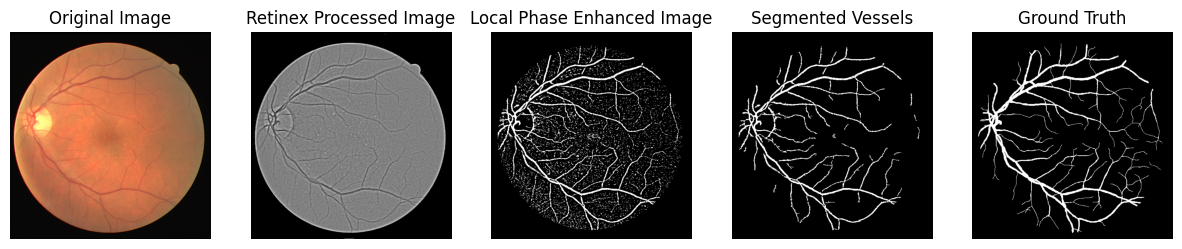

In [64]:
sample_img = cv.imread('images/input/1.png', cv.IMREAD_COLOR_RGB)
gt = cv.imread('images/gt/1.png', cv.IMREAD_GRAYSCALE)
r,g,b = cv.split(sample_img)
gray_img = cv.cvtColor(sample_img, cv.COLOR_RGB2GRAY)
retinex_img = bilateral_retinex(g) # using green channel for better vessel contrast 
segmented_image = segment(retinex_img, cv.imread('images/fov_mask.png', cv.IMREAD_GRAYSCALE))
enhanced_image = remove_small_objects(segmented_image)

plt.figure(figsize=(15,5))
plt.subplot(1,5,1)
plt.title('Original Image')
plt.imshow(sample_img, cmap='gray')
plt.axis('off')
plt.subplot(1,5,2)
plt.title('Retinex Processed Image')
plt.imshow(retinex_img, cmap='gray')
plt.axis('off')
plt.subplot(1,5,3)
plt.title('Local Phase Enhanced Image')
plt.imshow(segmented_image, cmap='gray')
plt.axis('off')
plt.subplot(1,5,4)
plt.title('Segmented Vessels')
plt.imshow(enhanced_image, cmap='gray')
plt.axis('off')
plt.subplot(1,5,5)
plt.title('Ground Truth')
plt.imshow(gt, cmap='gray')
plt.axis('off')
plt.savefig('output/detected_vessels.png')
plt.show()

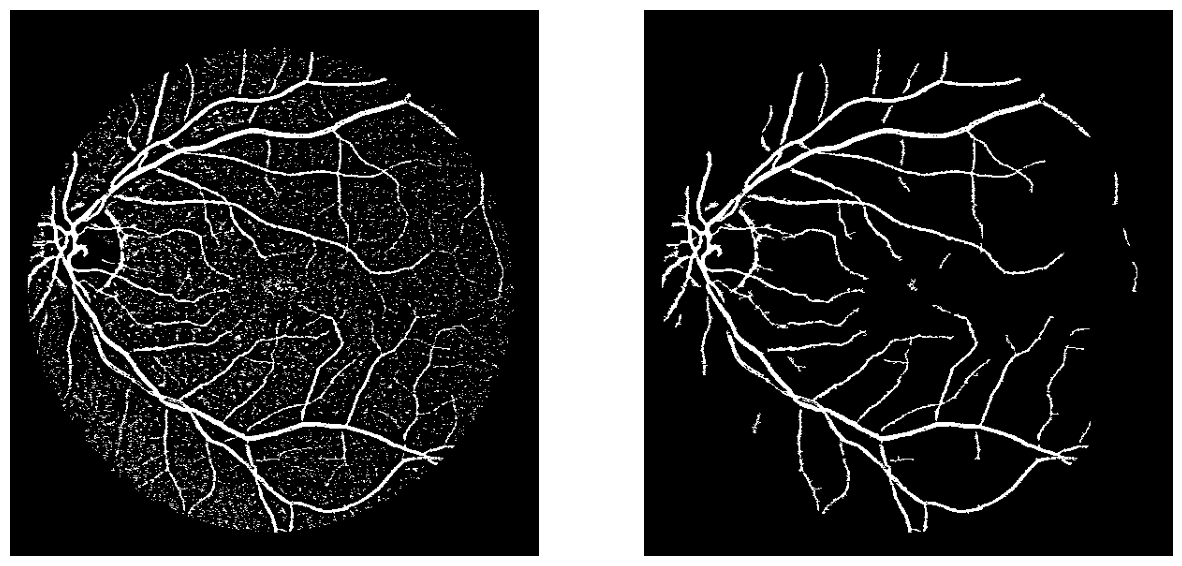

In [54]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(segmented_image, cmap='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(enhanced_image, cmap='gray')
plt.axis('off')
plt.show()

In [55]:
def vessel_segmentation(input_image):

    img = cv.imread(input_image, cv.IMREAD_COLOR_RGB)

    r,g,b = cv.split(img)
    retinex_img = bilateral_retinex(g)
    segmented_image = segment(retinex_img, cv.imread('images/fov_mask.png', cv.IMREAD_GRAYSCALE))
    enhanced_image = remove_small_objects(segmented_image)

    return enhanced_image

Your project will be evaluated with the Intersection over Union (IoU) metric, commonly used in segmentation tasks. This is the function to read a ground truth image and return the IoU considering your segmented image.

In [56]:
def single_IoU(img_name):

    # Apply segmentation
    input_img = os.path.join(db_path, 'input', img_name)
    obtained = vessel_segmentation(input_img)

    # Path of the target (ground truth) image
    path_target = os.path.join(db_path, 'gt', img_name)
    solution = cv.imread(path_target, cv.IMREAD_GRAYSCALE)

    # Show obtained results
    plt.imshow(obtained, cmap=plt.get_cmap('gray'))
    plt.show()

    # IoU calculation
    intersectionAB = cv.countNonZero(obtained & solution)
    unionAB = cv.countNonZero(obtained | solution)
    score = intersectionAB / unionAB
    print("Image {} - IoU={}".format(img_name, score))

    return score

This is the evaluation method that reads all the images from the input folder and gets the mean IoU for all of them. This is the score of your project, the higher the better.

['8.png', '9.png', '14.png', '15.png', '17.png', '16.png', '12.png', '13.png', '11.png', '10.png', '20.png', '18.png', '19.png', '4.png', '5.png', '7.png', '6.png', '2.png', '3.png', '1.png']


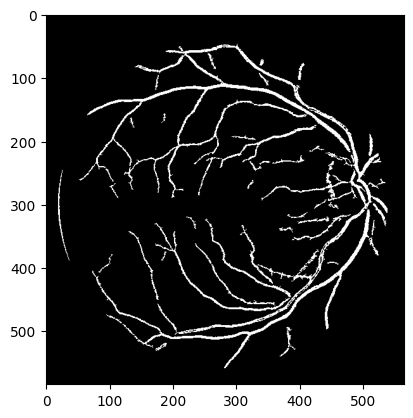

Image 8.png - IoU=0.517753184621592


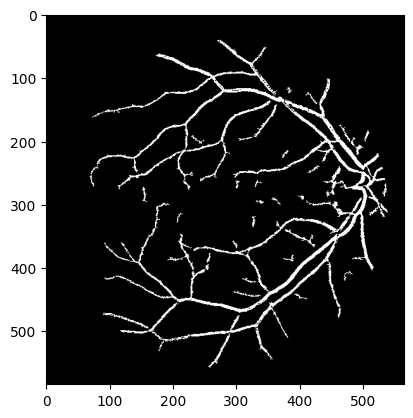

Image 9.png - IoU=0.5240794129209803


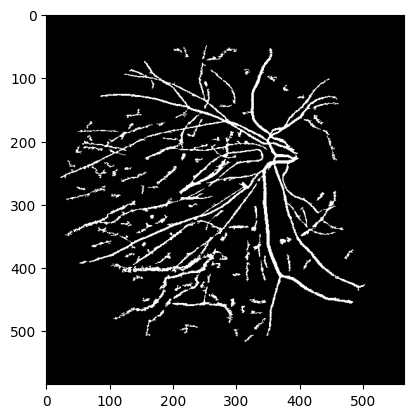

Image 14.png - IoU=0.43683043960103435


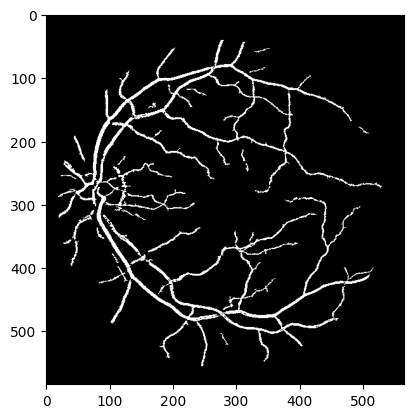

Image 15.png - IoU=0.5851525534344918


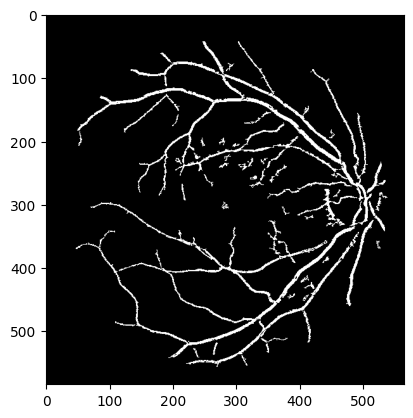

Image 17.png - IoU=0.5479599936497856


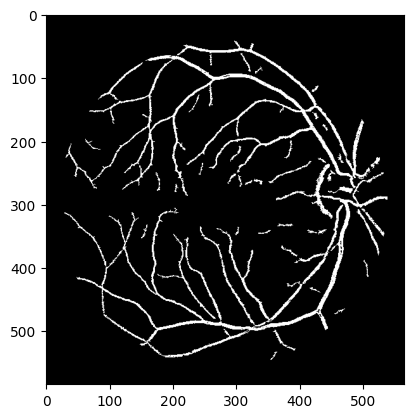

Image 16.png - IoU=0.5258131267575742


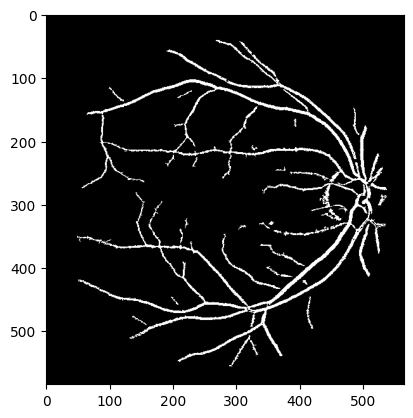

Image 12.png - IoU=0.5681123391675346


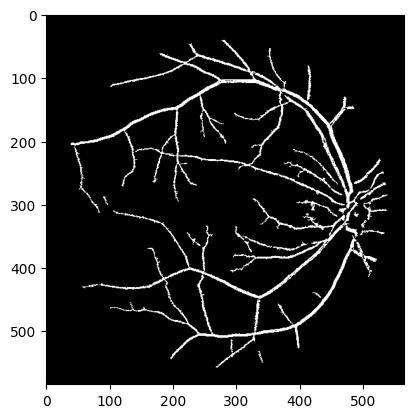

Image 13.png - IoU=0.5666507078859175


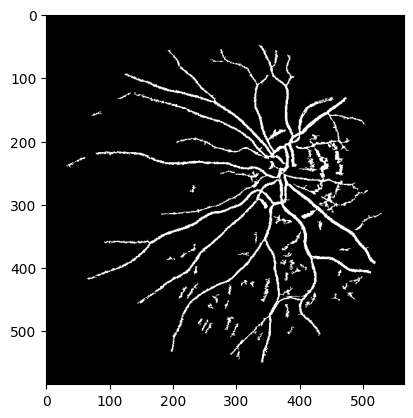

Image 11.png - IoU=0.517691888949374


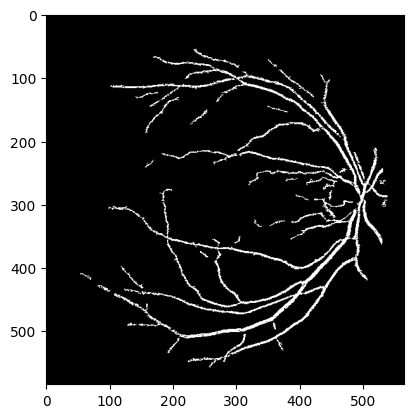

Image 10.png - IoU=0.4927796562411947


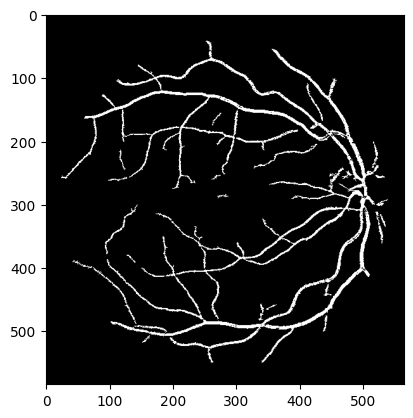

Image 20.png - IoU=0.5815686274509804


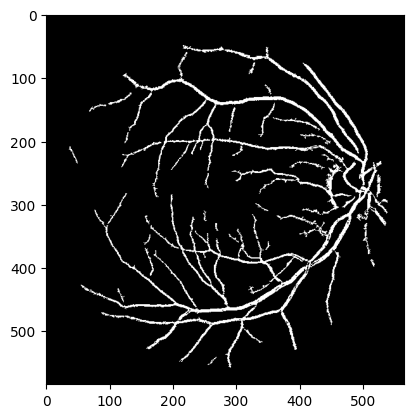

Image 18.png - IoU=0.5718241606092074


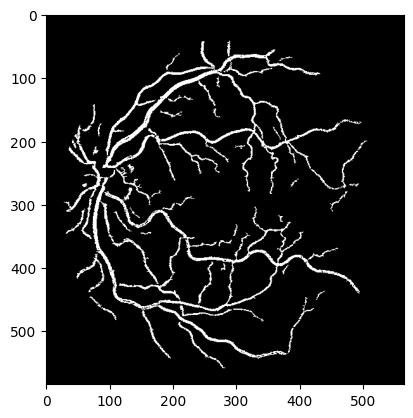

Image 19.png - IoU=0.5662018151345539


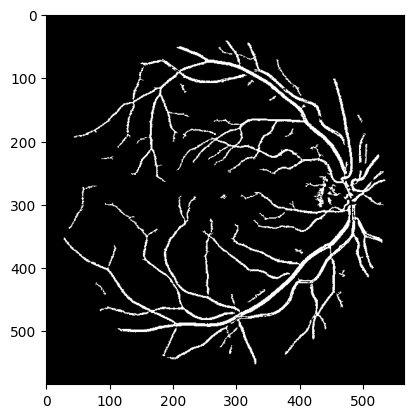

Image 4.png - IoU=0.5415067359072778


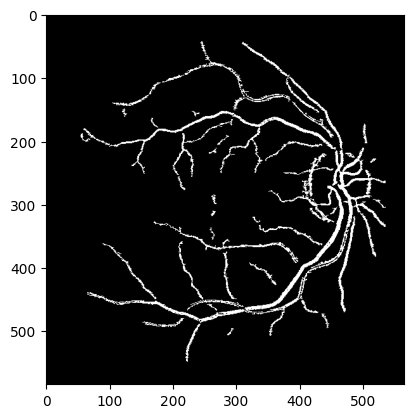

Image 5.png - IoU=0.4335268677054328


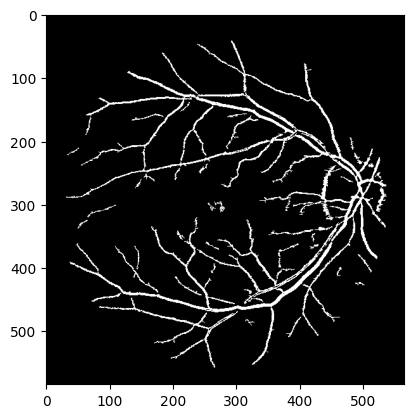

Image 7.png - IoU=0.5412031570443104


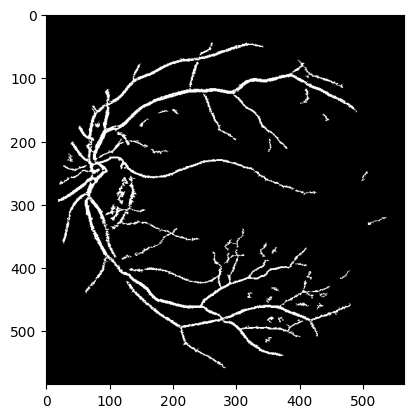

Image 6.png - IoU=0.4926916575519539


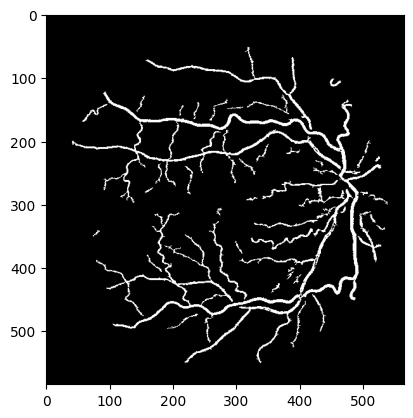

Image 2.png - IoU=0.5373706520383992


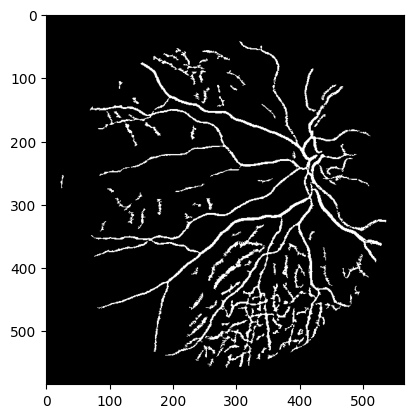

Image 3.png - IoU=0.41066606660666066


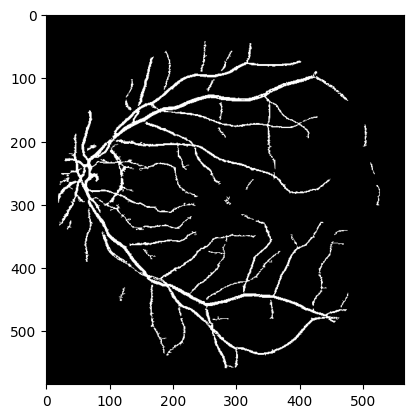

Image 1.png - IoU=0.5806324252539392
------------------------------------
Mean IoU=0.5270007734266097


In [57]:

meanIoU=0

path_input = os.path.join(db_path, 'input')

# List images in input folder
imgs = [f for f in os.listdir(path_input) if f.endswith('.png')]
print(imgs)

# For each image
for img in imgs:
    meanIoU += single_IoU(img)

# Average
meanIoU /= len(imgs)
print("------------------------------------")
print("Mean IoU={}".format(meanIoU))
